# Notebook de test

Notebook de Mickael MELKOWSKI

## Preprocessing des data

### Conversion en 256*256 et masking

In [4]:
# import
import cv2
import os
import pathlib

#### Config

In [5]:
# config
# chemin relatif vers le dossier data
path_to_data = pathlib.Path("../data")

data_folder_path = path_to_data / "raw" / "COVID-19_Radiography_Dataset"
output_path = path_to_data / "processed" / "covid_19_masked_tiny_500"
folder_to_process = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# Setting to output a smaller dataset of tiny_size number of images per type
make_tiny = True
tiny_size = 500

print(data_folder_path)


../data/raw/COVID-19_Radiography_Dataset


#### Converting

In [51]:
for img_type in  folder_to_process:
    print(f"Processing folder: {img_type}")

    img_folder_path = data_folder_path / img_type / "images"
    mask_folder_path = data_folder_path / img_type / "masks"

    output_folder_path = output_path / img_type
    output_folder_path.mkdir(parents=True, exist_ok=True)

    nb_image_done = 0
    for image_name, mask_name in zip(os.listdir(img_folder_path),
                                     os.listdir(mask_folder_path)):

        image_path = img_folder_path / image_name
        mask_path = mask_folder_path / mask_name

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resized to mask size
        image = cv2.resize(image, dsize = (256, 256)) # fixed size to mask size

        # masking
        res =  cv2.bitwise_and(image, image, mask=mask)

        # Write masked image
        output_image_name = image_name + '_masked.png'
        cv2.imwrite(output_folder_path / output_image_name, res)

        nb_image_done += 1
        if make_tiny and nb_image_done >= tiny_size:
            break

    print(f"Processing folder: {img_type} done.")

Processing folder: Lung_Opacity
Processing folder: Lung_Opacity done.
Processing folder: COVID
Processing folder: COVID done.
Processing folder: Normal
Processing folder: Normal done.
Processing folder: Viral_Pneumonia
Processing folder: Viral_Pneumonia done.


### Affichage d'une image par type.

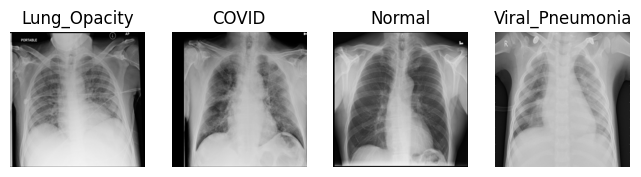

In [52]:
# affichage d'une images par type
import matplotlib.pyplot as plt
import numpy as np
import random
import os

plt.figure(figsize=(8,8))
j=1
for img_type in  folder_to_process:
    img_folder_path = data_folder_path / img_type / "images"

    list_dir = os.listdir(img_folder_path)
    i = random.randint(0, len(list_dir))

    image_path = img_folder_path / list_dir[i]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    plt.subplot(2,2,j)
    plt.axis('off')
    plt.imshow(image)
    plt.title(img_type)
    j+=1

In [ ]:
# affichage de 2 images par type
import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(16,8))
j=1
for img_type in  folder_to_process:
    img_folder_path = data_folder_path / img_type / "images"

    list_dir = os.listdir(img_folder_path)

    # 1st img
    i = random.randint(0, len(list_dir))

    image_path = img_folder_path / list_dir[i]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    plt.subplot(2,4,j)
    plt.axis('off')
    plt.imshow(image)
    plt.title(img_type)
    j+=1

    # 2nd image
    i = random.randint(0, len(list_dir))

    image_path = img_folder_path / list_dir[i]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    plt.subplot(2,4,j)
    plt.axis('off')
    plt.imshow(image)
    plt.title(img_type)
    j+=1

## Premiers models

### Tensorflow

In [1]:
# import
import pathlib

import numpy as np

import tensorflow as tf
# import tensorrt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

2024-10-26 19:14:00.112432: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 19:14:00.120906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729962840.129579  122552 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729962840.132249  122552 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 19:14:00.142574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# see if gpu can be used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Config

In [59]:
data_dir = output_path
img_height, img_width = 256, 256
batch_size = 32


#### Loading data

In [60]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 4 classes.
Using 1600 files for training.


I0000 00:00:1729962857.187481  122552 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode= "grayscale",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 4 classes.
Using 400 files for validation.


#### Keras to numpy

In [7]:
# Transform keras dataset to numpy ndarray
# from https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
# For train data
all_images = []
all_labels = []

for images, labels in train_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_train = np.concatenate(all_images)
y_train = np.concatenate(all_labels)

# For test data
all_images = []
all_labels = []

for images, labels in val_ds.take(-1):  # -1 takes all
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images)
y_test = np.concatenate(all_labels)


2024-10-26 19:14:31.049579: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-26 19:14:31.170371: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Normalization & Encoding

In [8]:
# normalization
X_train = X_train / 255
X_test = X_test / 255

# encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Test sur archi LeNet

### Definition du modele

In [9]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")
conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = 4,
                activation = 'softmax')

x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)
x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

lenet = Model(inputs = inputs, outputs = outputs)

/home/tylio/code/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilation et fitting

In [10]:
# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

# Entraînement_1
nb_epochs = 16
nb_batch_size = 200

training_history_lenet = lenet.fit(X_train, y_train,           # données
                                   validation_split = 0.2,     # split de test
                                   epochs = nb_epochs,         # nombre d'epochs
                                   batch_size = nb_batch_size) # taille des batchs

# extraire les précisions sur les bases d'entraînement et de test obtenues pendant l'entraînement
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

Epoch 1/16


I0000 00:00:1729962894.496981  123013 service.cc:148] XLA service 0x7f595800a3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729962894.497067  123013 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-10-26 19:14:54.515681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729962894.575542  123013 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-10-26 19:14:55.195115: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_865', 180 bytes spill stores, 180 bytes spill loads

I0000 00:00:1729962901.762199  123013 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3648 - loss: 1.3318 - val_accuracy: 0.5594 - val_loss: 1.0024
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6075 - loss: 0.9252 - val_accuracy: 0.5437 - val_loss: 0.9417
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6680 - loss: 0.7940 - val_accuracy: 0.6344 - val_loss: 0.8806
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7754 - loss: 0.6148 - val_accuracy: 0.5938 - val_loss: 0.8976
Epoch 5/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8226 - loss: 0.4770 - val_accuracy: 0.6438 - val_loss: 0.9318
Epoch 6/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8693 - loss: 0.3789 - val_accuracy: 0.6062 - val_loss: 1.0177
Epoch 7/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9121 - loss: 0.2576 - val_accuracy: 0.6438 - val_loss: 1.0273
Epoch 8/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9631 - loss: 0.1619 - val_accuracy: 0.6375 - val_loss: 1.1796
Epoch 9/16
7

### Plot

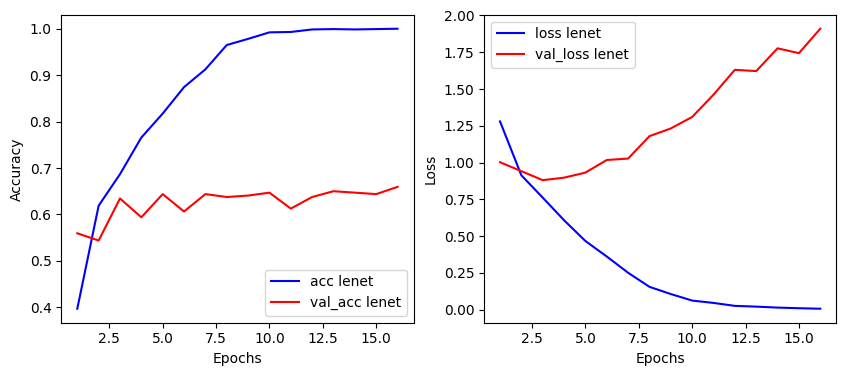

In [11]:
loss_lenet = training_history_lenet.history['loss']
val_loss_lenet = training_history_lenet.history['val_loss']


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         train_acc_lenet, 
         label = 'acc lenet',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_lenet,
         label = 'val_acc lenet',
         color = 'red')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()

plt.subplot(1,2,2)
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         loss_lenet, 
         label = 'loss lenet',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_loss_lenet,
         label = 'val_loss lenet',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

In [13]:
lenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 252, 252, 30)   │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 16)   │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,634,818 (90.16 MB)

 Trainable params: 7,878,272 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,756,546 (60.11 MB)

In [51]:
# import 
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Prediction
test_pred_lenet = lenet.predict(X_test)

# Appliquer la méthode argmax sur les tableaux pour obtenir 
# des vecteurs d'entiers correspondant aux classes prédites et réelles
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 
              precision    recall  f1-score   support

           0       0.49      0.46      0.47        90
           1       0.70      0.57      0.63        92
           2       0.58      0.68      0.63       107
           3       0.78      0.83      0.80       111

    accuracy                           0.65       400
   macro avg       0.64      0.63      0.63       400
weighted avg       0.65      0.65      0.64       400



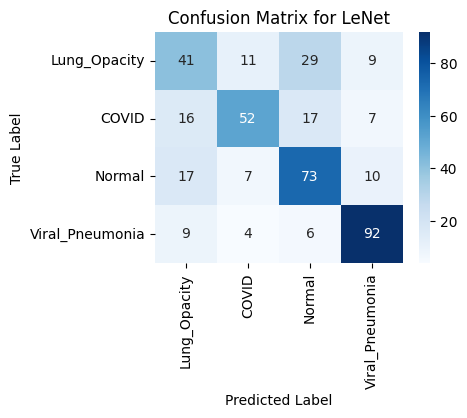

In [77]:
# Confusion matrix
# Compute confusion matrix
cm = confusion_matrix(y_test_class, test_pred_lenet_class)

# Optionally normalize the confusion matrix (if you want percentage instead of raw counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualization 
# get real label names
class_names = ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"]

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LeNet')
plt.show()

## Test load direct

Cas d'utilisation de Keras dataset directement plutot que de convertir en numpy

### Import

In [3]:
# import
import cv2
import os
import pathlib


import numpy as np

# import tensorrt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt

### Load dataset

In [4]:
data_dir = pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny_500")
img_height, img_width = 256, 256
batch_size = 32

# test sans passer par la recup à la main
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",  # Automatically infer labels from subdirectories
    label_mode="categorical",  # For multi-class classification
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),  # Resize images to a standard size
    batch_size=32,  # Set the batch size
    color_mode= "grayscale",
    shuffle=True  # Shuffle the dataset for better training
)

Found 2000 files belonging to 4 classes.
Using 1600 files for training.
Found 2000 files belonging to 4 classes.
Using 400 files for validation.


I0000 00:00:1730054063.264956   87394 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27 19:34:23.662088: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Model definition

In [5]:
# model definition
num_classes = 4

model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Normalization(axis=-1),  # Normalizes along the last axis (features), per batch ?
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes --> 4
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/home/tylio/code/radio_pulmo_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 256, 256, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,528,529 (360.60 MB)

 Trainable params: 31,509,508 (120.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 63,019,018 (240.40 MB)

### Fitting

In [6]:
# model.summary()
nb_epochs = 10
model_history = model.fit(train_dataset, 
                          epochs=nb_epochs,
                          validation_data=test_dataset)  # Adjust the number of epochs as needed

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.3387 - loss: 246.3089 - val_accuracy: 0.4700 - val_loss: 1.2273
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.6534 - loss: 0.9208 - val_accuracy: 0.5775 - val_loss: 1.0465
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - accuracy: 0.8492 - loss: 0.4546 - val_accuracy: 0.6025 - val_loss: 1.0908
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.9682 - loss: 0.1317 - val_accuracy: 0.5950 - val_loss: 1.3769
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.9923 - loss: 0.0286 - val_accuracy: 0.5875 - val_loss: 1.6588
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.5750 - val_loss: 1.8451
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.5750 - val_loss: 1.9968
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - accuracy: 1.0000 - loss: 7.3733e-04 - va

### Plot

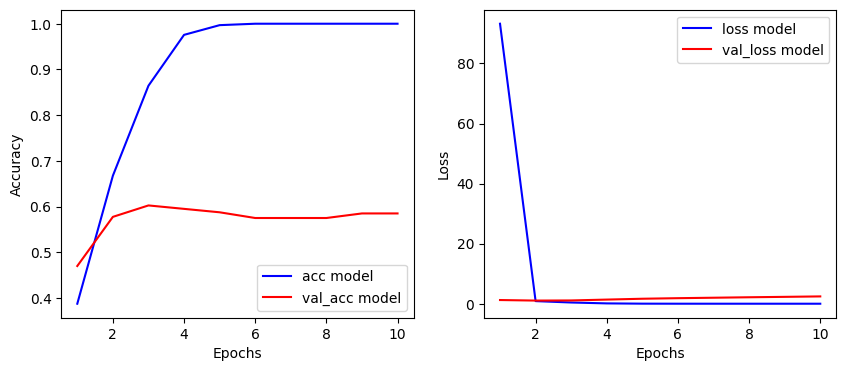

In [7]:
# Courbe du score de test du réseau test
# train_acc_model = model_history.history['accuracy']

a = """
val_acc_model = model_history.history['accuracy']

plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_model, 
         label = 'model test',
         color = 'blue')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()
"""

acc_model = model_history.history['accuracy']
val_acc_model = model_history.history['val_accuracy']
loss_model = model_history.history['loss']
val_loss_model = model_history.history['val_loss']


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         acc_model, 
         label = 'acc model',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_acc_model,
         label = 'val_acc model',
         color = 'red')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()

plt.subplot(1,2,2)
# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         loss_model, 
         label = 'loss model',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         val_loss_model,
         label = 'val_loss model',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### Prediction model test

In [1]:
# import 
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-10-27 19:34:00.799389: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 19:34:01.154404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 19:34:01.288887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 19:34:01.322473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 19:34:01.577490: I tensorflow/core/platform/cpu_feature_guar

In [8]:
# Make Predictions on the Dataset
# Get the true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert categorical labels to integer
    pred_labels.extend(np.argmax(preds, axis=1))  # Convert softmax output to predicted class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-10-27 19:37:54.203643: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Confusion matrix

In [9]:
# Confusion matrix
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optionally normalize the confusion matrix (if you want percentage instead of raw counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

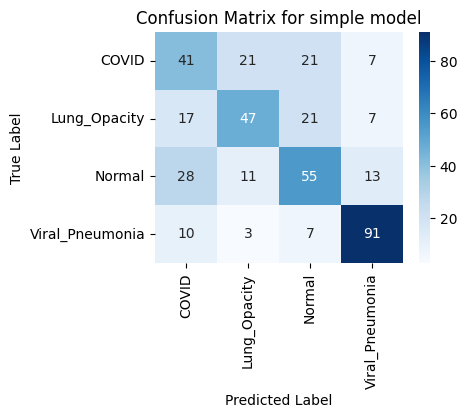

In [10]:
# Visualization 
# get real label names
class_names = test_dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.xticks(x, labels, rotation='vertical')
plt.title('Confusion Matrix for simple model')
plt.show()

## PyTorch

### Test model

In [6]:
import torch
torch.cuda.is_available()

True

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pathlib

# config
dataset_path = output_path
# pathlib.Path("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny_500")

# Définir les transformations (optionnel, mais recommandé)
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Redimensionne les images
    transforms.ToTensor(),  # Convertit les images en tenseurs
])

# Charger les données à partir du dossier
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
#dataset_test = datasets.ImageFolder(root='Testing', transform=transform)

#### Normalization

In [10]:
# mean and std for normalization
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

mean, std = get_mean_std(loader)

# Définir les transformations (optionnel, mais recommandé)
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Redimensionne les images
    transforms.ToTensor(),  # Convertit les images en tenseurs
    transforms.Normalize(mean=mean, std=std)  # normalize
])

# Charger les données à partir du dossier
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [11]:
dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

In [12]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..2921985.8].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..2977378.8].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..2381903.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..2381903.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..2645020.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51518536..3032772.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

Shape X : torch.Size([32, 3, 256, 256])
Shape y : torch.Size([32])


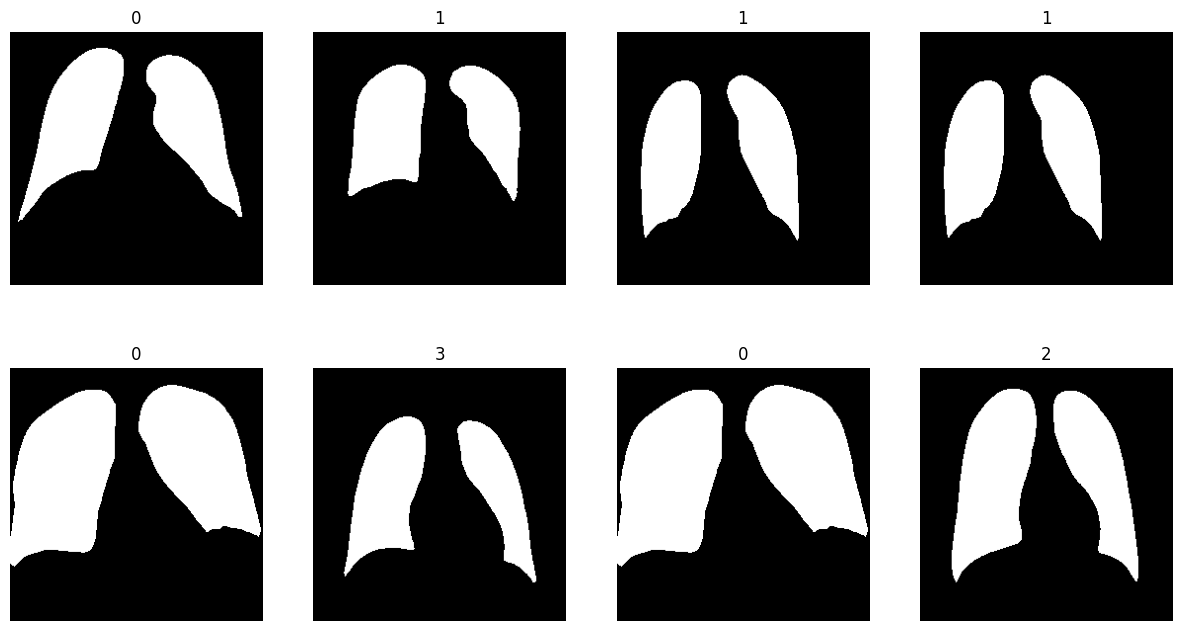

In [15]:
import matplotlib.pyplot as plt
import numpy as np
X_t, y_t = next(iter(dataloader_train))
print(f"Shape X : {X_t.shape}")
print(f"Shape y : {y_t.shape}")
plt.figure(figsize=(15,8))
j=1
for i in np.random.randint(0, len(X_t), size=[8]):
    plt.subplot(2,4,j)
    plt.axis('off')
    im = X_t[i].permute(1, 2, 0)
    plt.imshow(im)
    plt.title(y_t[i].item())
    j+=1

#### Model definition

In [85]:
import torch.nn as nn
device = "cuda"
model = nn.Sequential(
   nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # output 16, 254, 254
   nn.MaxPool2d(kernel_size=2), # output 16, 127, 127
   nn.ReLU(),
    
   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 32, 125, 125
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=2), # output 32, 62, 62
    
   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # output  64, 60, 60
   nn.ReLU(),
   nn.MaxPool2d(kernel_size=2), # output 64, 30, 30
    
   nn.Flatten(),
   nn.Linear(64 * 30 * 30, 64), # on précise ici la dim finale --> 64, 30, 30
   nn.ReLU(),
   nn.Linear(64, 4)

)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=57600, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=4, bias=True)
)

#### Summary

In [58]:
from torchsummary import summary
summary(model, input_size=(3,256,256), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
              ReLU-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          18,496
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
          Flatten-10                [-1, 57600]               0
           Linear-11                   [-1, 64]       3,686,464
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 4]             260
Total params: 3,710,308
Trainable param

#### Test loss function

In [59]:
X_batch, y_batch = next(iter(dataloader_train))

# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

y_pred = model(X_batch.to(device))

criterion(y_pred, y_batch.to(device))

tensor(1.3776, device='cuda:0', grad_fn=<NllLossBackward0>)

### Fitting

In [60]:
from torch import optim
from tqdm.notebook import tqdm
epochs = 10

# Définition de l'optimizer
optimizer = optim.Adam(model.parameters(), 1e-2)


for epoch in range(epochs):
    # Dans ce mode certaines couches du modèle agissent différemment
    model.train()
    loss_total = 0
    # Barre de progression
    progress_bar = tqdm(
            dataloader_train, desc="Epoch {:1d}".format(epoch), leave=True, disable=False
        )
    
    for i, batch in enumerate(progress_bar):
        # Batch de données
        X_batch, y_batch = batch
        
        # Device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Gradient mis 0
        model.zero_grad()

        # Calcul de prédiction
        y_pred = model(X_batch.to(torch.float32))

        # Calcul de la fonction de perte
        loss =  criterion(y_pred, y_batch) #torch.mean(torch.abs(y_pred- y_batch.to(torch.float32)))#
        # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        #  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Descente de gradient : actualisation des paramètres
        optimizer.step()
        
        loss_total += loss.item()
        
        progress_bar.set_postfix(
            {
                "training_loss": "{:.3f}".format(loss_total/(i+1))}
        )

Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

### Evaluation

In [61]:
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate(dataloader_val):
    # Passer le modèle en évaluation
    model.eval()
    # Calculer la loss totale
    loss_val_total = 0
    # Stocker les prédictions et les vraies valeurs.
    predictions, true_vals = [], []
    for batch in dataloader_val:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            # Prédiction du modèle pour un batch donné
            y_pred = model(X_batch.to(torch.float32))
        # Calcul de la fonction de perte pour l'utiliser comme une métrique
        loss = criterion(y_pred, y_batch)
        # Cummuler la fonction de perte de tous les lots de données.
        loss_val_total += loss.item()
        # Enregistrer les prédictions pour les utiliser plus tard
        predictions.extend(y_pred.detach().cpu().numpy())
        # Enregistrer les vraies valeurs pour les utiliser plus tard
        true_vals.extend(y_batch.cpu().numpy())

    # Loss du jeu de données val
    loss_val_avg = loss_val_total / len(dataloader_val)
    # Ensemble des prédictions du jeu de données
    predictions = np.array(predictions)
    # Id prediction
    predictions = np.argmax(predictions, axis=-1)
    # Ensemble des vraies valeurs du jeu de données
    true_vals = np.array(true_vals)
    return {"loss":loss_val_avg, "accuracy":accuracy_score(true_vals, predictions)}


metrics = evaluate(dataloader_test)

print(f"Loss: {metrics['loss']}")
print(f"Accuracy : {metrics['accuracy']}")

Loss: 1.3901405429840088
Accuracy : 0.24625


### Confusion matrix

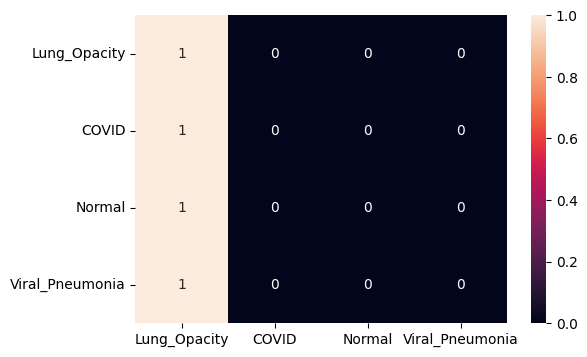

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

on_cuda = True # computed using cuda

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
    if on_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = folder_to_process

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True)


## Test on DenseNet-121 architecture

Using tuto on kaggle: [covid-19-detection-pytorch-tutorial](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image


### Model loading

In [6]:
class_names = folder_to_process
device="cuda"

def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

/home/tylio/code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tylio/code/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Number of param to train

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6957956


#### Training function

In [8]:
dataloaders = {"train":dataloader_train, 
               "val":dataloader_test}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}

metrics = {
    "acc":[],
    "val_acc":[],
    "loss":[],
    "val_loss":[],
}

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))

            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]

            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print(f'{phase} Loss: {epoch_loss:.4f} | {phase} Accuracy: {epoch_acc:.4f} | Kappa Score: {epoch_kappa:.4f}')
                metrics["acc"].append(float(epoch_acc))
                metrics["loss"].append(float(epoch_loss))
            else:
                print(f'{phase} Loss: {epoch_loss:.4f} | {phase} Accuracy: {epoch_acc:.4f}')
                metrics["val_acc"].append(float(epoch_acc))
                metrics["val_loss"].append(float(epoch_loss))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

NameError: name 'dataloader_train' is not defined

### Visual function

In [15]:
print(mean)
print(std)

tensor(1.4601e-07)
tensor(2.8343e-07)


In [15]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [mean, mean, mean]
std_nums = [std, std, std]

def imshow(inp, size =(30,30), title=None, normalized=True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    if normalized:
        mean = mean_nums
        std = std_nums
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

NameError: name 'dataloaders' is not defined

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [63]:
nb_epochs = 10
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, num_epochs=nb_epochs)

Epoch 1/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5733 | train Accuracy: 0.7844


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5724 | val Accuracy: 0.7825 | Kappa Score: 0.6986
Val loss Decreased from inf to 0.5724 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5725 | train Accuracy: 0.7819


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5741 | val Accuracy: 0.7875 | Kappa Score: 0.7059

Epoch 3/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5819 | train Accuracy: 0.7806


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5705 | val Accuracy: 0.7875 | Kappa Score: 0.7052
Val loss Decreased from 0.5724 to 0.5705 
Saving Weights... 

Epoch 4/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5652 | train Accuracy: 0.7838


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5729 | val Accuracy: 0.7850 | Kappa Score: 0.7018

Epoch 5/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5797 | train Accuracy: 0.7769


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5789 | val Accuracy: 0.7700 | Kappa Score: 0.6832

Epoch 6/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5712 | train Accuracy: 0.7812


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5773 | val Accuracy: 0.7775 | Kappa Score: 0.6924

Epoch 7/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5880 | train Accuracy: 0.7781


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5697 | val Accuracy: 0.7850 | Kappa Score: 0.7017
Val loss Decreased from 0.5705 to 0.5697 
Saving Weights... 

Epoch 8/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5687 | train Accuracy: 0.7888


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5766 | val Accuracy: 0.7750 | Kappa Score: 0.6895

Epoch 9/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5707 | train Accuracy: 0.7825


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5699 | val Accuracy: 0.7900 | Kappa Score: 0.7083

Epoch 10/10
----------


train:   0%|          | 0/50 [00:00<?, ?it/s]

train Loss: 0.5671 | train Accuracy: 0.7900


val:   0%|          | 0/13 [00:00<?, ?it/s]

val Loss: 0.5704 | val Accuracy: 0.7825 | Kappa Score: 0.6984

Training complete in 1m 28s
Best val loss: 0.5697


### Saving

In [19]:
torch.save(model.state_dict(), "/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/models/pytorch/dense121_normalized.pt")

### Loading

In [14]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load("/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/models/pytorch/dense121.pt", weights_only=True))
model.eval()

NameError: name 'TheModelClass' is not defined

### Eval and visualisation

In [ ]:
visualize_model(base_model)
plt.show()

### Accuracy and loss

In [64]:
print(metrics["acc"])

[0.79, 0.7875, 0.7825, 0.7725, 0.7875, 0.78, 0.79, 0.7825, 0.7875, 0.79, 0.785, 0.7875, 0.7825, 0.785, 0.7875, 0.785, 0.78, 0.7925, 0.785, 0.785, 0.7875, 0.785, 0.7875, 0.785, 0.79, 0.785, 0.7825, 0.7875, 0.7875, 0.785, 0.77, 0.7775, 0.785, 0.775, 0.79, 0.7825]


ValueError: x and y must have same first dimension, but have shapes (10,) and (36,)

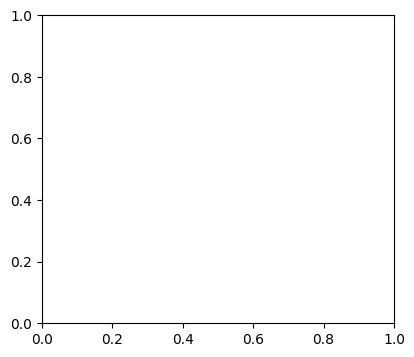

In [65]:
# use metrics dict from train function

nb_epochs = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# Courbe du score de test du réseau Dense 121
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["acc"], 
         label = 'acc Dense121',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["val_acc"],
         label = 'val_acc Dense121',
         color = 'red')
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Affichage de la légende
plt.legend()

plt.subplot(1,2,2)
# Courbe du score de test du réseau Dense 121
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["loss"], 
         label = 'loss Dense121',
         color = 'blue')
plt.plot(np.arange(1 , nb_epochs + 1, 1),
         metrics["val_loss"],
         label = 'val_loss Dense121',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Affichage de la légende
plt.legend()
# Affichage de la figure
plt.show()

### Confusion Matrix

Text(45.58159722222221, 0.5, 'True Label')

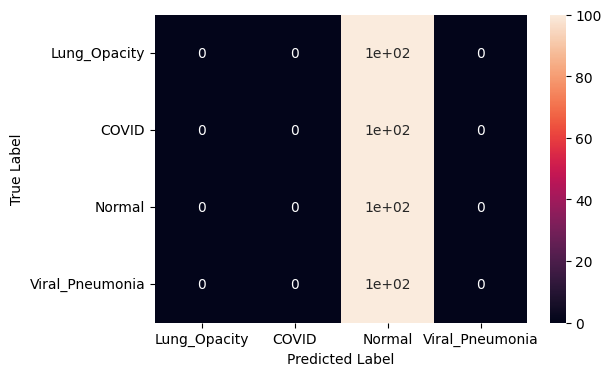

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

on_cuda = True # computed using cuda

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
    if on_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = folder_to_process

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(100*cf_matrix / np.sum(cf_matrix, axis=1)[:, None], 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## Test classif classique ?

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


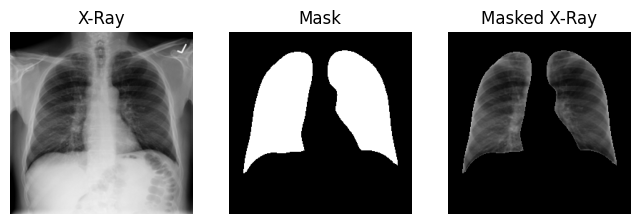

In [58]:
# affichage d'une images par type
import matplotlib.pyplot as plt
import cv2

def plot_fig(title, img_path, location):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    print(type(image))
    plt.subplot(1, 3, location)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title)


plt.figure(figsize=(8,8))
j=1
img = "../data/raw/COVID-19_Radiography_Dataset/Normal/images/Normal-12.png"
mask = "/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/raw/COVID-19_Radiography_Dataset/Normal/masks/Normal-12.png"
masked = "/home/tylio/code/Project_radio_pulmo/code/radio_pulmo/data/processed/covid_19_masked_tiny/Normal/Normal-12.png_masked.png"

plot_fig("X-Ray", img, j)
j+=1
plot_fig("Mask", mask, j)
j+=1
plot_fig("Masked X-Ray", masked, j)
j+=1